<a href="https://colab.research.google.com/github/asem3mustafa/Fake-News-Detection/blob/main/Face_mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from math import ceil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as gh
gh.download("https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asemmustafa
Your Kaggle Key: ··········


100%|██████████| 330M/330M [00:04<00:00, 79.0MB/s]

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

#Data generator
train_data=train_datagen.flow_from_directory(directory='/content/face-mask-12k-images-dataset/Face Mask Dataset/Train',
                                             target_size=(128,128),
                                             class_mode='categorical',
                                             batch_size=32)
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory='/content/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
                                                  target_size=(128,128),
                                                  class_mode='categorical',
                                                  batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory='/content/face-mask-12k-images-dataset/Face Mask Dataset/Test',
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
#VGG19 model
model_file = '.h5'

if os.path.exists(model_file):
    model=load_model(model_file)
else:
    vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

    for layer in vgg19.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(2, activation = "sigmoid"))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Training
#model=load_model("MaskDetectionnnbetter.h5")
train_steps_per_epoch = ceil(len(train_data) / 32)
val_steps_per_epoch = ceil(len(val_generator) / 32)

history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=4,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch)

<ipython-input-9-fc76a0430f80>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/4
10/10 [==============================] - 16s 366ms/step - loss: 0.5828 - accuracy: 0.7188 - val_loss: 0.4058 - val_accuracy: 0.8438
Epoch 2/4
10/10 [==============================] - 2s 239ms/step - loss: 0.2936 - accuracy: 0.9250 - val_loss: 0.2777 - val_accuracy: 0.9062
Epoch 3/4
10/10 [==============================] - 3s 317ms/step - loss: 0.1835 - accuracy: 0.9469 - val_loss: 0.1330 - val_accuracy: 0.9688
Epoch 4/4
10/10 [==============================] - 2s 237ms/step - loss: 0.1731 - accuracy: 0.9531 - val_loss: 0.0762 - val_accuracy: 1.0000


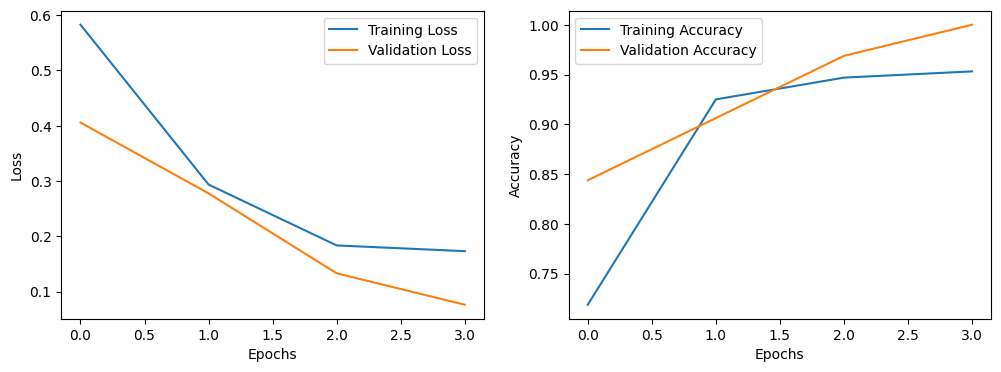

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<Axes: >

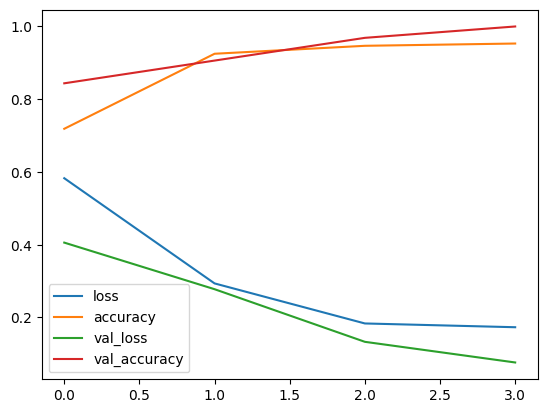

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.save('MaskDetectionModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_alt (1).xml')

In [ ]:
def classif_imag(img):
  plt.figure(figsize=(5,5))
  #processing img
  k_img = cv2.imread(img)
  sample_mask_img = cv2.resize(k_img,(128,128))
  sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
  sample_mask_img = sample_mask_img/255.0
##############################################
      #classification img
  class_img=model.predict(sample_mask_img)
  if class_img[0][0]>.51:
    result='Mask'
    color=(0,255,0)
  else:
    result='No mask'
    color=(255,0,0)
   ##########################################
        #out put
  img = cv2.cvtColor(k_img, cv2.IMREAD_GRAYSCALE)
  faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

  out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

  #plotting
  for (x,y,w,h) in faces:
      cv2.rectangle(out_img,(x,y),(x+w,y+h),color,1)
      cv2.putText(out_img, result, (x, y+10), cv2.FONT_HERSHEY_SIMPLEX, .5, color, 1)
  plt.imshow( out_img)
  print(class_img)

1/1 [==============================] - 0s 19ms/step
[[0.92409486 0.01712246]]


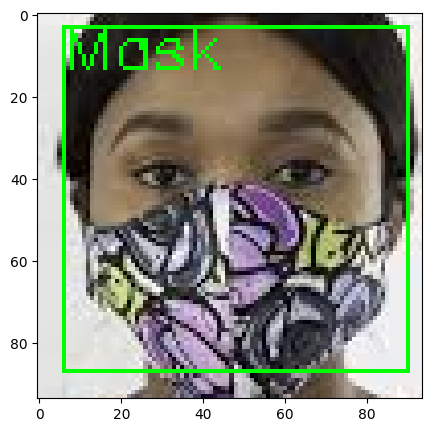

In [ ]:
classif_imag('/content/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1405.png')

1/1 [==============================] - 0s 34ms/step
[[0.03255698 0.98988605]]


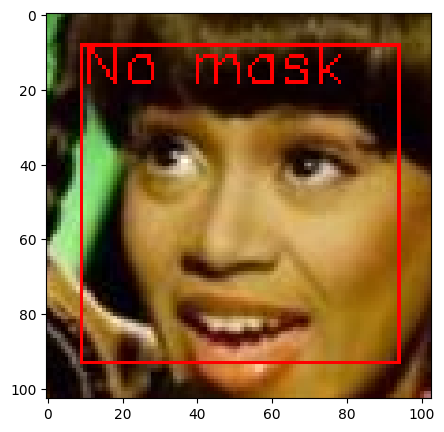

In [ ]:
classif_imag('/content/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1767.png')